# Generative Adverserial Network (GAN) with Cyrillic Data 
Chase Yakaboski, 11/7/2018

## 1. Data Preparation
    - Image loading function
    - Load in of images 
    - Plot histogram of Labels
    
## 2. GAN with one Cyrillic Character
    - Preprocess Data
    - Split Data into Training and Testing
    - Define Generator
    - Define Discriminator
    - Define a Training Function
    - Analysis
    
## 3. GAN with all Characters
    - Preprocess/load data
    - Retrain (uses the One Character Cyrillic Results as a starting point.)
    
## 4. References

In [14]:
import numpy as np
import pandas
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.datasets import mnist
from keras.layers import Input, Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook

print(tf.__version__)

1.12.0


## 1. Data Preparation

In [17]:
#-- Function to Load in Data
#-- This Function expects images to be in seperated folders in which each folder is a different character. 

def load_images(path_to_images='../Cyrillic', image_size=40):
    #-- First we change directory to the path to images.
    os.chdir(path_to_images)
    letter_class = [name for name in os.listdir() if os.path.isdir(name)]
    num_classes = len(letter_class)

    images = []
    images_2d = []
    labels = []
    for i in range(0, num_classes):
        for j, file in enumerate(os.listdir(os.path.join(os.getcwd(), letter_class[i]))):
            try:
                path = os.path.join(os.getcwd(), letter_class[i], file)
                im = cv2.imread(path, cv2.IMREAD_UNCHANGED)
                res = cv2.resize(im, dsize=(image_size, image_size))
                r,g,b,a = cv2.split(res)
                im = np.array(a)
                #- Add a dummy dimension
                im = np.expand_dims(im, axis=2)
                images_2d.append(im)
                im_alpha = np.squeeze(im.reshape(-1, image_size**2),axis=0)
                #- Normalize Pixel Values
                im_alpha2 = im_alpha / 255.0 
                images.append(im_alpha2)
                labels.append(i)
            except:
                print('Bad Files:')
                print(path)
                continue
    images = np.array(images)
    labels = np.array(labels)
    images_2d = np.array(images_2d)
    labels_2d = keras.utils.to_categorical(labels, num_classes = num_classes)
    
    return images, images_2d, labels, labels_2d, letter_class

In [5]:
images, images_2d, labels, labels_2d, letter_class = load_images(image_size=28)

### Now lets plot the labels to make sure each Cyrillic letter has about the same number of samples. 

(array([247., 469., 444., 487., 424., 465., 576., 344., 462., 431., 447.,
        466., 459., 433., 470., 508., 465., 474., 493., 513., 456., 551.,
        463., 486., 448., 464., 431., 446., 459., 415., 427., 458., 461.,
        438.]),
 array([ 0.        ,  0.97058824,  1.94117647,  2.91176471,  3.88235294,
         4.85294118,  5.82352941,  6.79411765,  7.76470588,  8.73529412,
         9.70588235, 10.67647059, 11.64705882, 12.61764706, 13.58823529,
        14.55882353, 15.52941176, 16.5       , 17.47058824, 18.44117647,
        19.41176471, 20.38235294, 21.35294118, 22.32352941, 23.29411765,
        24.26470588, 25.23529412, 26.20588235, 27.17647059, 28.14705882,
        29.11764706, 30.08823529, 31.05882353, 32.02941176, 33.        ]),
 <a list of 34 Patch objects>)

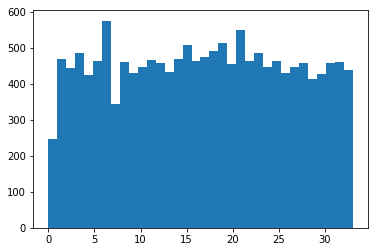

In [18]:
plt.hist(labels, bins=34)

## 2. GAN using just one Cyrillic Character

In [78]:
#-- Preprocess
random_seed = 2
samples_train, samples_test, labels_train, labels_test =  train_test_split(images, labels, 
                                                                           test_size=0)
samples_train = samples_train[np.where(labels_train==2)]
print('We will be training only on this cyrillic letter:', letter_class[2])

We will be training only on this cyrillic letter: Б


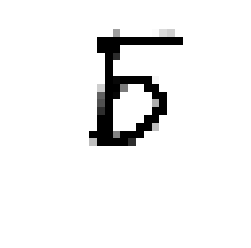

A sample from the data.


In [67]:
test = samples_train[7].reshape(28,28)
plt.imshow(test, interpolation='nearest', cmap='gray_r')
plt.axis('off')
plt.show()
print('A sample from the data.')

In [68]:
#-- Define a Noise Function
def noise_fun(size_x, size_y):
    return np.random.normal(0,1,size=(size_x, size_y))

In [69]:
#-- Define Noise Dimension:
z_dim = 100

In [70]:
#-- Build Generator
adam = Adam(lr=0.0001, beta_1=0.5)

generator = Sequential()

generator.add(Dense(256, input_dim=z_dim, activation='relu'))
generator.add(LeakyReLU(alpha=0.3))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(512))
generator.add(LeakyReLU(alpha=0.3))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(1024))
generator.add(LeakyReLU(alpha=0.3))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(samples_train[0].shape[0], activation='relu'))

generator.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [71]:
#-- Build Discriminator
discriminator = Sequential()

discriminator.add(Dense(1024, input_dim=samples_train[0].shape[0], activation='relu'))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512, activation='relu'))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256, activation='relu'))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))  # Values between 0 and 1

discriminator.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

discriminator.trainable = False
inputs = Input(shape=(z_dim, ))
hidden = generator(inputs)
output = discriminator(hidden)
gan = Model(inputs, output)
gan.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [72]:
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_14 (Sequential)   (None, 784)               1493520   
_________________________________________________________________
sequential_15 (Sequential)   (None, 1)                 1460225   
Total params: 2,953,745
Trainable params: 1,489,936
Non-trainable params: 1,463,809
_________________________________________________________________


In [73]:
#-- Lets define some plots (Plot functions taken from [1])
def plot_loss(losses):
    """
    @losses.keys():
        0: loss
        1: accuracy
    """
    d_loss = [v[0] for v in losses["D"]]
    g_loss = [v[0] for v in losses["G"]]
    #d_acc = [v[1] for v in losses["D"]]
    #g_acc = [v[1] for v in losses["G"]]
    
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    #plt.plot(d_acc, label="Discriminator accuracy")
    #plt.plot(g_acc, label="Generator accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def plot_generated(n_ex=10, dim=(1, 10), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, z_dim))
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(n_ex, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [74]:
#-- Set up a vector (dict) to store the losses
losses = {"D":[], "G":[]}

#-- training function taken from [1].
def train(epochs=1, plt_frq=1, BATCH_SIZE=128):
    batchCount = int(samples_train.shape[0] / BATCH_SIZE)
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)
    
    for e in tqdm_notebook(range(1, epochs+1)):
        if e == 1 or e%plt_frq == 0:
            print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batchCount):  # tqdm_notebook(range(batchCount), leave=False):
            # Create a batch by drawing random index numbers from the training set
            image_batch = samples_train[np.random.randint(0, samples_train.shape[0], size=BATCH_SIZE)]
            # Create noise vectors for the generator
            noise = noise_fun(BATCH_SIZE, z_dim)
            
            # Generate the images from the noise
            generated_images = generator.predict(noise)
            X = np.concatenate((image_batch, generated_images))
            # Create labels
            y = np.zeros(2*BATCH_SIZE)
            y[:BATCH_SIZE] = 0.95  # One-sided label smoothing

            # Train discriminator on generated images
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y)

            # Train generator
            noise = noise_fun(BATCH_SIZE, z_dim)
            y2 = np.ones(BATCH_SIZE)
            discriminator.trainable = False
            g_loss = gan.train_on_batch(noise, y2)

        # Only store losses from final batch of epoch
        losses["D"].append(d_loss)
        losses["G"].append(g_loss)

        # Update the plots
        if e == 1 or e%plt_frq == 0:
            plot_generated()
    plot_loss(losses)

Epochs: 200
Batch size: 75
Batches per epoch: 5


--------------- Epoch 1 ---------------


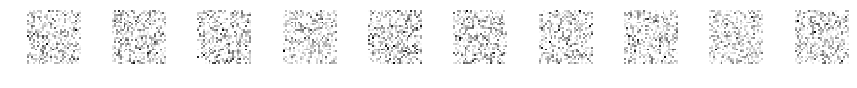

--------------- Epoch 20 ---------------


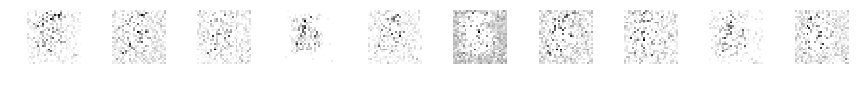

--------------- Epoch 40 ---------------


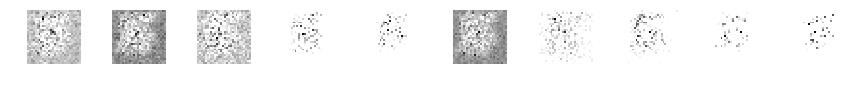

--------------- Epoch 60 ---------------


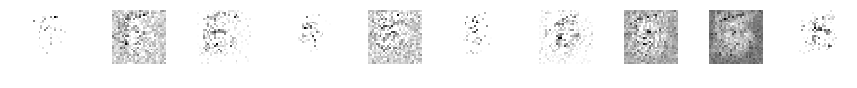

--------------- Epoch 80 ---------------


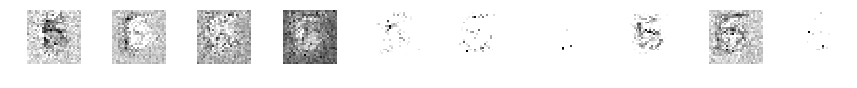

--------------- Epoch 100 ---------------


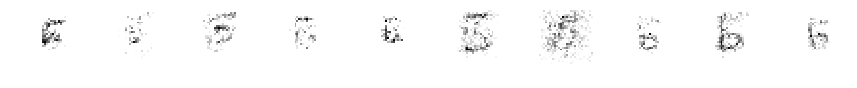

--------------- Epoch 120 ---------------


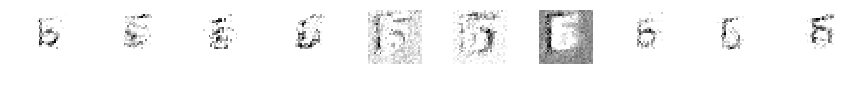

--------------- Epoch 140 ---------------


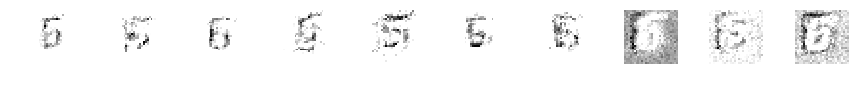

--------------- Epoch 160 ---------------


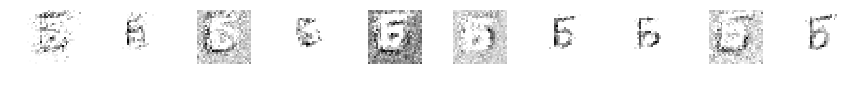

--------------- Epoch 180 ---------------


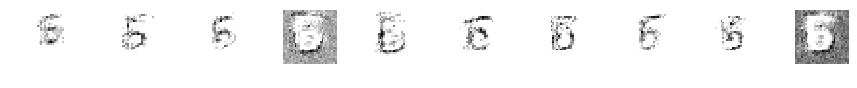

--------------- Epoch 200 ---------------


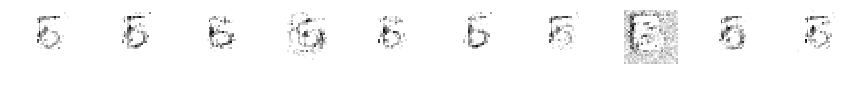

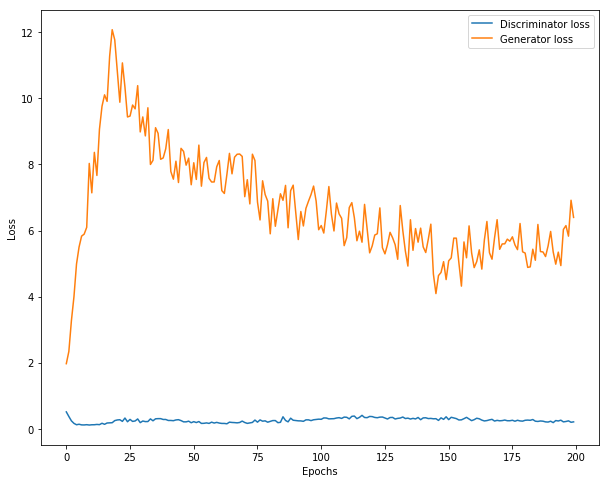

In [75]:
train(epochs=200, plt_frq=20, BATCH_SIZE=75)

## 3. GAN with all Cyrillic Characters

In [76]:
#-- Preprocess
samples_train, samples_test, labels_train, labels_test =  train_test_split(images, labels, test_size=0)

Epochs: 200
Batch size: 75
Batches per epoch: 206


--------------- Epoch 1 ---------------


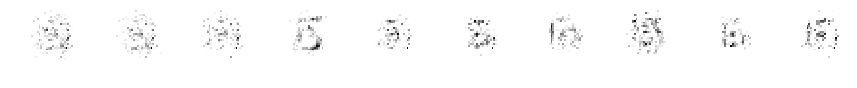

--------------- Epoch 20 ---------------


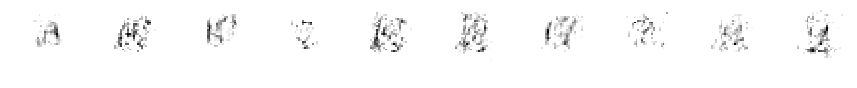

--------------- Epoch 40 ---------------


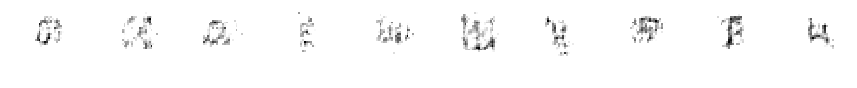

--------------- Epoch 60 ---------------


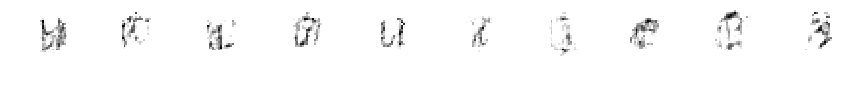

--------------- Epoch 80 ---------------


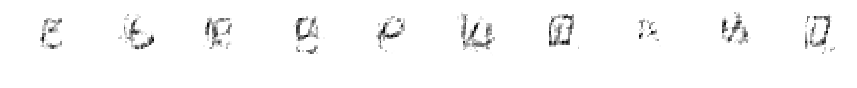

--------------- Epoch 100 ---------------


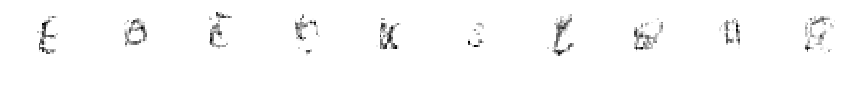

--------------- Epoch 120 ---------------


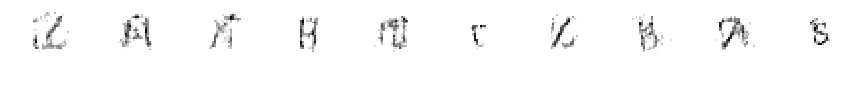

--------------- Epoch 140 ---------------


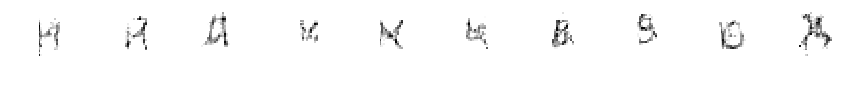

--------------- Epoch 160 ---------------


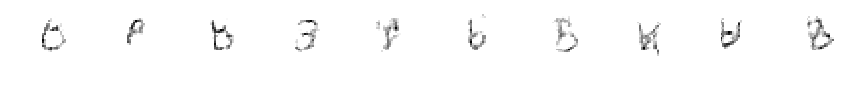

--------------- Epoch 180 ---------------


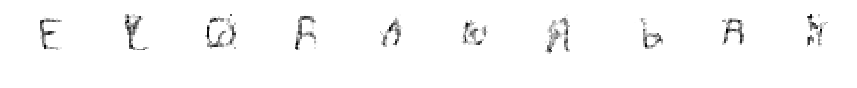

--------------- Epoch 200 ---------------


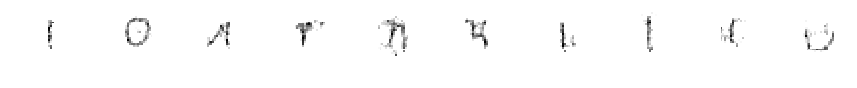

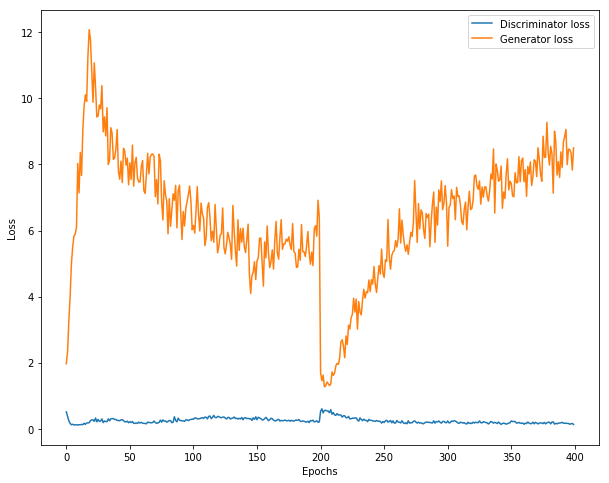

In [77]:
train(epochs=200, plt_frq=20, BATCH_SIZE=75)

### Graph Rationale
The graph above is a little unusual because the final trained GAN from the single character was used as the starting model for the complete Cyrillic data set. It was found in practice that begining the training of the complete (generalized) GAN on the pre-trained single Cyrillic GAN led to more interesting results than training of the complete GAN from scratch.

## 4. References:
1. https://github.com/kroosen/GAN-in-keras-on-mnist/blob/master/GAN-keras-mnist-MLP.ipynb
2. https://github.com/diegoalejogm/gans
3. https://towardsdatascience.com/understanding-and-optimizing-gans-going-back-to-first-principles-e5df8835ae18